In [137]:
import pyvisa
import pandas as pd
import numpy as np


In [217]:

rm = pyvisa.ResourceManager()
resources = rm.list_resources()
resource = resources[0]
spectrum_analyzer_resource = rm.open_resource(resource)

In [221]:
class SpectrumAnalyzer:
    def __init__(self, spectrum_analyzer_resource):
        self.spectrum_analyzer_resource = spectrum_analyzer_resource

    def get_id(self) -> str:
        return self.format_response(self.spectrum_analyzer_resource.query('*IDN?'))
    
    def set_center_frequency(self, frequency : float):
        self.ensure_range(0, 7.5e9, frequency)
        self.spectrum_analyzer_resource.write(f'SENSe:FREQuency:CENTer {frequency}')
    
    def get_center_frequency(self) -> float:
        return float(self.format_response(self.spectrum_analyzer_resource.query('SENSe:FREQuency:CENTer?')))
    
    def set_start_frequency(self, frequency : float):
        self.ensure_range(0, 7.5e9, frequency)
        self.spectrum_analyzer_resource.write(f'SENSe:FREQuency:STARt {frequency}')
    
    def get_start_frequency(self) -> float:
        return float(self.format_response(self.spectrum_analyzer_resource.query('SENSe:FREQuency:STARt?')))
    
    def set_stop_frequency(self, frequency : float):
        self.ensure_range(0, 7.5e9, frequency)
        self.spectrum_analyzer_resource.write(f'SENSe:FREQuency:STOP {frequency}')

    def get_stop_frequency(self) -> float:
        return float(self.format_response(self.spectrum_analyzer_resource.query('SENSe:FREQuency:STOP?')))
    
    def set_span(self, span : float):
        self.ensure_range(0, 7.5e9, span)
        self.spectrum_analyzer_resource.write(f'SENSe:FREQuency:SPAN {span}')

    def get_span(self) -> float:
        return float(self.format_response(self.spectrum_analyzer_resource.query('SENSe:FREQuency:SPAN?')))

    def enable_tracking_generator(self):
        self.spectrum_analyzer_resource.write('OUTPut:STATe ON')

    def disable_tracking_generator(self):
        self.spectrum_analyzer_resource.write('OUTPut:STATe OFF')

    def is_tracking_generator_enable(self)-> bool:
        return self.format_response(self.spectrum_analyzer_resource.query('OUTPut:STATe?')) == '1'
    
    def set_tracking_generator_offset(self, level: int):
        self.ensure_range(-200, 200, level)
        self.spectrum_analyzer_resource.write(f'SOURce:CORRection:OFFSet {level}')

    def get_tracking_generator_offset(self) -> float:
        return float(self.format_response(self.spectrum_analyzer_resource.query('SOURce:CORRection:OFFSet?')))
    
    def set_tracking_generator_level(self, level: int):
        self.ensure_range(-40, 0, level)
        self.spectrum_analyzer_resource.write(f'SOURce:POWer:LEVel:IMMediate:AMPLitude {level}')

    def get_tracking_generator_level(self) -> float:
        return float(self.format_response(self.spectrum_analyzer_resource.query('SOURce:POWer:LEVel:IMMediate:AMPLitude?')))

    def get_harmonics_frequency(self) -> np.array:
        return self.format_response(self.spectrum_analyzer_resource.query(':READ:HARMonics:FREQuency:ALL?'))
    
    def ensure_range(self, min, max, value):
        if value < min and value > max:
            raise ValueError(f'Value must be between {min} and {max}')
    
    def format_response(self, response):
        return response.strip()


In [222]:
spectrum_analyzer = SpectrumAnalyzer(spectrum_analyzer_resource)

In [223]:
frequency = 100e6
spectrum_analyzer.set_center_frequency(frequency)
spectrum_analyzer.set_span(10e3)

In [224]:
print(spectrum_analyzer.get_start_frequency())
print(spectrum_analyzer.get_stop_frequency())

706766662.0
706766662.0


In [227]:
x = spectrum_analyzer_resource.query("TRACe:DATA? TRACE1")
x = x.split(" ", 1)[-1]

x = x.split(",")

x = [float(a) for a in x]
x

[-0.5787792,
 -0.5788536,
 -0.5771809,
 -0.5771809,
 -0.580904,
 -0.5744896,
 -0.5743446,
 -0.5807247,
 -0.5767288,
 -0.5744514,
 -0.5758228,
 -0.5745373,
 -0.5733433,
 -0.5780373,
 -0.5863419,
 -0.5798225,
 -0.5790119,
 -0.5778866,
 -0.5777855,
 -0.580286,
 -0.5859451,
 -0.5830326,
 -0.5820313,
 -0.5848846,
 -0.5874691,
 -0.5898266,
 -0.5864677,
 -0.5827789,
 -0.5830879,
 -0.5809669,
 -0.5774918,
 -0.578043,
 -0.582653,
 -0.5734711,
 -0.5650463,
 -0.5648499,
 -0.5706959,
 -0.5810604,
 -0.5823669,
 -0.5835304,
 -0.5895939,
 -0.6007538,
 -0.5872879,
 -0.5766335,
 -0.5764065,
 -0.5819168,
 -0.5774517,
 -0.573204,
 -0.5731354,
 -0.5754318,
 -0.5766163,
 -0.57757,
 -0.5827084,
 -0.5777912,
 -0.57728,
 -0.5808182,
 -0.5710964,
 -0.567997,
 -0.569376,
 -0.5686779,
 -0.5661545,
 -0.5704174,
 -0.5804691,
 -0.5866165,
 -0.5834732,
 -0.5801945,
 -0.5773659,
 -0.5762691,
 -0.5727081,
 -0.569809,
 -0.5698071,
 -0.5724392,
 -0.5788307,
 -0.5757504,
 -0.5668316,
 -0.5616322,
 -0.5616322,
 -0.5640297

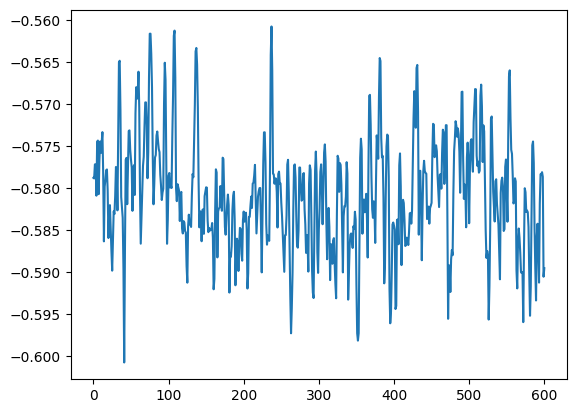

In [228]:
from matplotlib import pyplot as plt

plt.figure()

plt.plot(x)

plt.show()

In [210]:
spectrum_analyzer_resource.query(':FETCH:CHPower?')

'7.425137E+00,-5.558517E+01\n'

In [166]:
spectrum_analyzer.get_harmonics_frequency()

'100004966,200009932,300014898,400019864,500024830,600029796,700034762,800039728,900044694,1000049660'

In [11]:
data = [{
    "plant": 'aloe_verra',
    "center_frequency": 0,
    "span": 0,
    "tracking_generator_offset": 0,
    "tracking_generator_level": 0,
}]

In [13]:
df = pd.DataFrame(data)

In [14]:
df

,plant,center_frequency,span,tracking_generator_offset,tracking_generator_level
0,aloe_verra,0,0,0,0
